In [1]:
%config Completer.use_jedi = False  # for tab auto complete

import pyro
import pyro.distributions as dist
from pyro import sample
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.poutine import trace

In [2]:
import torch
import torch.distributions.constraints as constraints

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.style.use(["science", "notebook", "grid"])

In [4]:
pyro.__version__

'1.8.1'

In [5]:
def pprint_trace(tr):
    """
    a simple utility to print a trace.
    a trace simply executes a DGM by sampling the random variables and stores their values.
    """
    from pprint import pprint
    pprint({
        name: {
            'value': props['value'],
            'prob': props['fn'].log_prob(props['value']).exp()
        }
        for (name, props) in tr.nodes.items()
        if props['type'] == 'sample'
    })

## Exponential-Normal Model (both `Z` and `X` are 1d): it defines the joint $p_{\theta}(\bf{x}, \bf{z})$

In [6]:
def exp_normal_model(data=None):
    lamb = torch.tensor(1.0)
    sigma = torch.tensor(1.0)
    
    z = pyro.sample("Z", pyro.distributions.Exponential(rate=lamb))

    pyro.sample("X", pyro.distributions.Normal(loc=z, scale=sigma),
                obs=data)

# Visualize/Render the DGM

## 1. if no data is passed, the DGM renders both as unobserved/latent variables

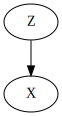

In [7]:
data=None
pyro.render_model(exp_normal_model, model_args=(data, ))

## example execution of model without data

In [6]:
tr = trace(exp_normal_model).get_trace()
pprint_trace(tr)

{'X': {'prob': tensor(0.3989), 'value': tensor(0.2333)},
 'Z': {'prob': tensor(0.8031), 'value': tensor(0.2193)}}


In [7]:
# just check the prob. values manually! (don't trust ha ha)
np.exp(-0.2193)

0.8030807577840431

In [8]:
(1/np.sqrt(2*np.pi)) * np.exp(-0.5 * (0.2193-0.2333)**2)

0.3989031859736116

## on passing some data, the `X` nodes get shaded
### note: you need to pass the data as a tensor, here `data` is = `[1.3]`

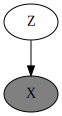

In [8]:
data=torch.ones(1) * 1.3
pyro.render_model(exp_normal_model, model_args=(data, ))

In [9]:
data

tensor([1.3000])

## example execution with any data=`1.3`

In [11]:
tr = trace(exp_normal_model).get_trace(data)
pprint_trace(tr)

{'X': {'prob': tensor([0.2003]), 'value': tensor([1.3000])},
 'Z': {'prob': tensor(0.8816), 'value': tensor(0.1260)}}


## note: here the value of `X` would always be sampled as 1.3, so prob. would be just the normal density function evaluated as `X=1.3` and `Z=`the sampled value

In [12]:
np.exp(-0.1260)

0.8816148467834161

In [13]:
(1/np.sqrt(2*np.pi)) * np.exp(-0.5 * (0.1260 - 1.3)**2)

0.2002724612653587

## Define the surrogate posterior $q_{\phi}(\bf{z})$
Note $\phi$ is the parameter of the surrogate distribution. Here it is the rate ($\lambda$) of the **proposed** Exponential distribution to approximate the posterior $p(\bf{z}|\bf{x})$

note: In `pyro`, the proposed surrogate posterior is also called the `guide`.

In [10]:
def guide(data=None):
    phi = pyro.param("phi", torch.tensor(1.0),
                      constraint=constraints.positive)
    
    pyro.sample("Z", pyro.distributions.Exponential(rate=phi))

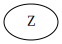

In [11]:
pyro.render_model(guide, model_args=(data, ))

## Learn the parameter $\phi$ using SVI

In [12]:
# set up the optimizer
pyro.clear_param_store()
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(exp_normal_model, guide, optimizer, loss=Trace_ELBO())

n_steps = 15000
# do gradient steps
param_vals = []
for step in range(n_steps):
    svi.step(data)
    param_vals.append({"phi": pyro.param("phi").item()})
    if step % 1000 == 0:
        print('.', end='')

...............

In [13]:
phi = pyro.param("phi").item()
phi

1.2721973657608032

## manually verify with the derived formula

# $\theta^* = -\frac{x-1}{2} + \sqrt{\frac{(x-1)^2}{4} + 2}$

In [14]:
x=1.3

In [15]:
theta_star = - (x-1)/2 + np.sqrt(2 + 0.25 * (x-1)**2)

In [16]:
theta_star

1.2721462653327893

In [17]:
pyro.param("phi")

tensor(1.2722, grad_fn=<AddBackward0>)

### convergence plot

array([<AxesSubplot:>], dtype=object)

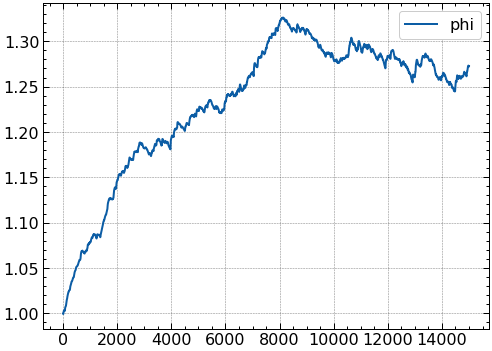

In [18]:
pd.DataFrame(param_vals).plot(subplots=True)

# Plotting the distributions

In [19]:
# define the range, it is also the support of z
rng = np.linspace(-1, 5, 1000)

In [20]:
rng.shape

(1000,)

## Prior on $\bf{z}$: $p(\bf{z}) = Exp(\bf{z}; \lambda=1)$

In [21]:
p_z = np.exp(-rng) * (rng >= 0)

## Joint (fixed on data $x^{[0]} = 1.3$)

# $p(z, x=x^{[0]}) = p(z)p(x=x^{[0]}|z) = \sqrt{\frac{1}{2\pi}} e^{-z} e^{\frac{1}{2} (x^{[0]} - z)^2} I(z \geq 0)$

In [22]:
x_0 = 1.3
p_joint = p_z * (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * (x_0 - rng)**2)
# plt.plot(rng, p_joint)

In [23]:
np.trapz(p_joint, rng)  # integrate to compute area

0.2776449919880252

## True posterior is just the joint (fixed to the data) divided by the normalization const. obtained above
just integrate out along z (rng here)

In [24]:
p_post = p_joint / np.trapz(p_joint, rng)

## surrogate posterior $q(\bf{z}) = Exp(\bf{z}; \lambda=\phi)$

In [25]:
q_z = phi * np.exp(-phi*rng) * (rng >= 0)

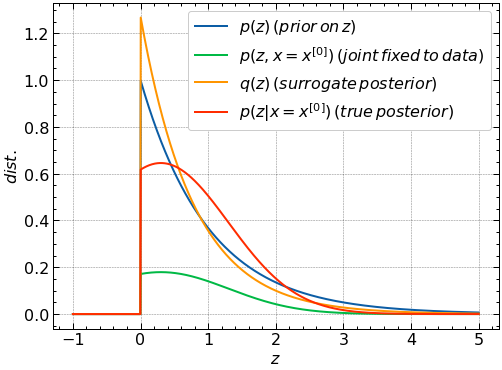

In [26]:
plt.plot(rng, p_z, label=r'$p(z)\, (prior\,on\,z)$')

plt.plot(rng, p_joint, label=r'$p(z, x=x^{[0]})\,(joint\,fixed\,to\,data)$')

plt.plot(rng, q_z, label=r'$q(z)\,(surrogate\,posterior)$')

plt.plot(rng, p_post, label=r'$p(z|x=x^{[0]})\,(true\,posterior)$')

plt.xlabel('$z$')
plt.ylabel('$dist.$')
plt.legend(loc = "upper right")

plt.show()